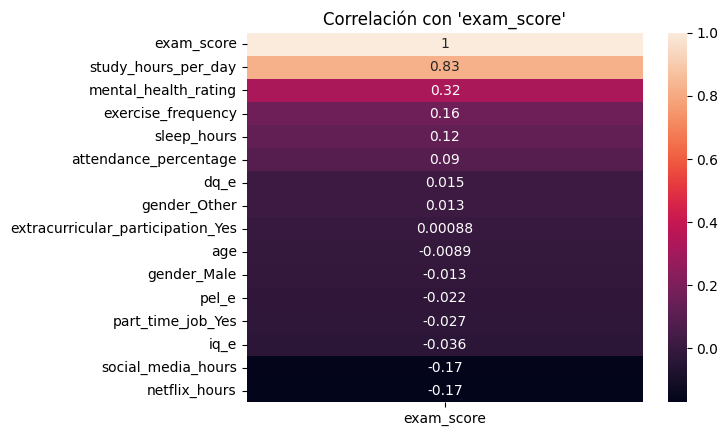

KNN (antes de limpiar) → R²: 0.566, RMSE: 10.55

--- Puntuaciones de características ---
age: 0.19
study_hours_per_day: 1726.33
social_media_hours: 30.76
netflix_hours: 22.86
attendance_percentage: 8.31
sleep_hours: 12.68
exercise_frequency: 17.52
mental_health_rating: 96.57
dq_e: 0.17
pel_e: 0.40
iq_e: 0.50
gender_Male: 0.63
gender_Other: 0.07
part_time_job_Yes: 0.85
extracurricular_participation_Yes: 0.10

Características seleccionadas: ['study_hours_per_day', 'social_media_hours', 'netflix_hours', 'sleep_hours', 'exercise_frequency', 'mental_health_rating']

KNN (tras selección de características) → R²: 0.791, RMSE: 7.31


In [2]:
#------------1. Importamos bibliotecas necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression

#------------2. Leemos y preparamos los datos
df = pd.read_csv('student_habits_performance.csv')
df['parental_education_level'] = df['parental_education_level'].fillna(df['parental_education_level'].mode()[0])

#------------3. Preprocesamiento de variables categóricas
diet_quality = {'Poor': 0, 'Fair': 1, 'Good': 2}
parental_education_level = {'High School': 0, 'Bachelor': 1, 'Master': 2}
internet_quality = {'Poor': 0, 'Average': 1, 'Good': 2}

df['dq_e'] = df['diet_quality'].map(diet_quality)
df['pel_e'] = df['parental_education_level'].map(parental_education_level)
df['iq_e'] = df['internet_quality'].map(internet_quality)

dummies = pd.get_dummies(df[['gender', 'part_time_job', 'extracurricular_participation']], drop_first=True)
df2 = pd.concat([df, dummies], axis=1)

df2 = df2.drop(['gender', 'part_time_job', 'diet_quality', 'parental_education_level', 
                'internet_quality', 'extracurricular_participation', 'student_id'], axis=1)

#------------4. División y estandarización
X = df2.drop('exam_score', axis=1)
y = df2['exam_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#------------5. Correlación con la variable objetivo
df_corr = df2.copy()
sns.heatmap(df_corr.corr()[['exam_score']].sort_values(by='exam_score', ascending=False), annot=True)
plt.title("Correlación con 'exam_score'")
plt.show()

#------------6. KNN antes de eliminar variables
knn_model = KNeighborsRegressor(n_neighbors=7)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))

print(f"KNN (antes de limpiar) → R²: {r2_knn:.3f}, RMSE: {rmse_knn:.2f}")

#------------7. Selección de características (estadística univariada)
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X_train_scaled, y_train)

print("\n--- Puntuaciones de características ---")
for feature, score in zip(X.columns, selector.scores_):
    print(f"{feature}: {score:.2f}")

# Tomamos solo las características más relevantes (score > 10 como umbral orientativo)
selected_features = [f for f, s in zip(X.columns, selector.scores_) if s > 10]
print("\nCaracterísticas seleccionadas:", selected_features)

#------------8. Entrenar KNN con solo variables seleccionadas
X_red = X[selected_features]
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(X_red, y, test_size=0.2, random_state=42)

scaler_red = StandardScaler()
X_train_red_scaled = scaler_red.fit_transform(X_train_red)
X_test_red_scaled = scaler_red.transform(X_test_red)

knn_model_red = KNeighborsRegressor(n_neighbors=7)
knn_model_red.fit(X_train_red_scaled, y_train_red)
y_pred_knn_red = knn_model_red.predict(X_test_red_scaled)

r2_knn_red = r2_score(y_test_red, y_pred_knn_red)
rmse_knn_red = np.sqrt(mean_squared_error(y_test_red, y_pred_knn_red))

print(f"\nKNN (tras selección de características) → R²: {r2_knn_red:.3f}, RMSE: {rmse_knn_red:.2f}")
